In [3]:
%load_ext autoreload
%autoreload 2

In [54]:
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

import enchant
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

import spacy

In [3]:
df = pd.read_csv('data/articles.csv', index_col='index') #parser.py uses BeautifulSoup to make a clean .csv from html files
df.date = pd.to_datetime(df.date)

BrainPickings.org has 5000+ articles containing 5 million words. The author is interested in the evolving themes in her work. While this can be visualized with a stacked barchart (years on x, count on y, stacking is based on tags), I want to turn this into an NLP problem involving vectorization of the articles and then classification. The classification can be done in two ways: time and tags. Time would predict Early (written before 2014) or Late (written 2014-present) while tags would divide articles by popular tags and then try to guess which tag the article is filed under. Tags should be different, like Science an Art, two popular ones. In order to use rarer tags, you will have to undersample the more popular class 

Classifying articles into one of many tage is a multi-label problem. You'll want to calculate probabilities for each tag for every document. When making the model, think about the target and how to best transform the "natural language" into a vector that captures the essence of the target. Suppose you want to classify an article as being about Art or Science. A basic model would be to look for the words "art" and "science" in the article and return a vector of the counts. So if an article says "art" once and "science" three times th vector is [1,3]. You want the simplest representation of the article that gives the clearest signal of what the classification should be.

If the classification is about whether the author wrote the article early in their career or later, then you'll want to represent the article as a different vector. Maybe the inexperinced writer used a lot of curse words or said "like" to much. Maybe the stronger writer writes longer sentences or uses a wider vocabulary. In this case, using too small a vocabulary will not be a good idea. You want to represent the early articles as sparser with more reliance on commoner words. 

In choosing the right vector to capture the right signal, you'll want to think about the particular problem. Do you need rare words, do you need to filter out words that occur in most articles, do you need stems or lemmas, do you need puncutation, do you want a few stop words or many? Be careful as well you don't make a useless model. Suppose you left t4he date in the article and the model just used that to predict when it was written. Or maybe the author always signed off with a phrase and then stopped doing it, so the model just sees that.

Topic modeling is the process of discovering salient feautures in a corpus in an unsupervied way. 

### 1.1 Make classes based on date
The reason for doing this classification may be to distinguish Maria's early and late writing style.

In [20]:
#Summer (June 21) 2014 is my dividing line
#This date divides the total word count more or less evenly.
df["early"] = 1
df.early[(df.date > '2014-06-20')] = 0

In [25]:
#the corpus includes all articles including titles
documents = df.title + df.content

In [26]:
#cleaning
documents = documents.str.lower()
documents = documents.str.replace(',','') # this keeps numbers together
documents = documents.str.replace('[^\w\s]',' ') # apostrophes divide a word, which works with nltk.stopwords

### 1.2 Feature Extraction with Tf-Idf vectorizer

In [32]:
TFIDF = TfidfVectorizer(strip_accents="unicode",
                             min_df=7,
                             max_df=.93,
                             stop_words='english') #ngram_range=(1,2)
X = TFIDF.fit_transform(documents)
X

<5698x23071 sparse matrix of type '<class 'numpy.float64'>'
	with 1667368 stored elements in Compressed Sparse Row format>

In [33]:
vocabulary = np.array(list(TFIDF.vocabulary_.keys()))
len(vocabulary)

23071

In [34]:
#scaling required for logit and pca
#sparse array will not center so MAKE IT DENSE
X = StandardScaler().fit_transform(X.todense())

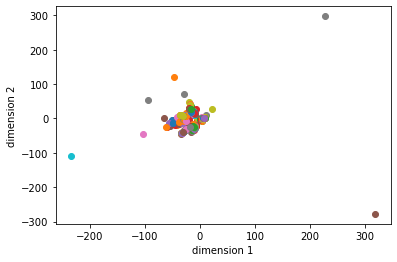

In [45]:
from sklearn import manifold

k = 4 #knn
d = 2 #dimensionality
pos = manifold.Isomap(k, d, eigen_solver='auto').fit_transform(X_scale)

# Plot the dimension reduced data
plt.xlabel('dimension 1')
plt.ylabel('dimension 2')
for i in range(1, len(pos)): plt.scatter(pos[i][0], pos[i][1]);

### 1.3 Modeling

In [38]:
y = df.early
y.value_counts() #first half has many shorter articles

1    3413
0    2285
Name: early, dtype: int64

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y, random_state=36)

In [46]:
X_train.shape

(4558, 23071)

In [48]:
#undersample Early class because a lot are stubs anyway
X_train, y_train = NearMiss().fit_resample(X_train, y_train.ravel())

In [49]:
X_train.shape

(3656, 23071)

#### 1.3.1 Logistic regression

In [50]:
lr = LogisticRegression()
lr.fit(X_train, y_train.ravel())
preds = lr.predict(X_test)

              precision    recall  f1-score   support

           0       0.87      0.90      0.88       457
           1       0.93      0.91      0.92       683

    accuracy                           0.91      1140
   macro avg       0.90      0.90      0.90      1140
weighted avg       0.91      0.91      0.91      1140



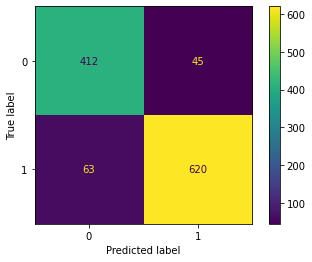

In [51]:
#already good
print(classification_report(y_test, preds))
plot_confusion_matrix(lr, X_test, y_test);

### EXTRA: Spacy

In [63]:
# Load English tokenizer, tagger, parser and NER
nlp = spacy.load("en_core_web_sm")

# Process whole documents
doc = nlp(df.content[1111])

# Analyze syntax
print("Noun phrases:", [chunk.text for chunk in doc.noun_chunks])
print("Verbs:", [token.lemma_ for token in doc if token.pos_ == "VERB"])

# Find named entities, phrases and concepts
for entity in doc.ents:
    print(entity.text, entity.label_)

Noun phrases: [' Scott Jordan', 'New York City', 'buried treasures', 'Jordan', 'the childhood hobby', 'a curious career', 'a self-trained historian', 'restorer', 'the intersection', 'history', 'archeology', 'urban scavenger hunting', 'Past Objects', 'Jordan', 'a fascinating look', 'the most interesting objects', 'his massive collection', 'he', 'shovels', 'mesh sieves', 'canvas rucksacks', 'sheer ingenuity', 'New York’s five boroughs', 'Jordan’s passion', 'strange and wonderful collectible remnants', 'his childhood', 'he', 'his brother', 'the woods', 'Connecticut', 'search', 'fossils', 'he', 'his family', 'NYC', 'him', 'a “city kid', 'he', 'his unusual hobby', 'his new urban surrounding', 'his forty-year search', 'New York City', 'I', 'what', 'our present time', 'people', 'the future', 'our landfills', 'a great source', 'well-preserved materials', 'forty', 'the bread-loaf shaped mounds', 'we', 'Its’ a strange thing', 'everything', 'we', 'our lives', 'everything', 'we', 'every day', 'one

### 2. A multi-label problem
#### Make classes based on tags

In [5]:
art, science, love, poetry, cinema, philosophy, psychology  = [],[],[],[],[],[],[]

for ix, tag in enumerate(df.tags):
    if re.match(".* art,.*", tag) or re.match("art,.*", tag): art.append(ix)

for ix, tag in enumerate(df.tags):
    if re.match(".*science,.*", tag): science.append(ix)

In [6]:
art_df=df.iloc[art]
art_df["art"]=1

sci_df=df.iloc[science]
sci_df["art"]=0

df2 = pd.concat([art_df, sci_df])

# ~250 articles are duplicates, tagged both art and science
# I remove them but is it a multi-label problem?
df2=df2[df2.index.value_counts()==1]
df2=df2.reset_index(drop=True)

### Science/art tag classes

In [51]:
y = df2.art
y.value_counts()

1    1827
0     939
Name: art, dtype: int64

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.2,
                                                    stratify=y, random_state=36)

In [52]:
X_train.shape

(2212, 25612)

In [53]:
#oversample science class
X_train, y_train = SMOTE().fit_resample(X_train, y_train.ravel())

In [54]:
X_train.shape

(2922, 25612)

### Logistic regression

In [58]:
lr = LogisticRegression()
lr.fit(X_train, y_train.ravel())
preds = lr.predict(X_test)

In [59]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.98      0.79      0.88       188
           1       0.90      0.99      0.95       366

    accuracy                           0.92       554
   macro avg       0.94      0.89      0.91       554
weighted avg       0.93      0.92      0.92       554



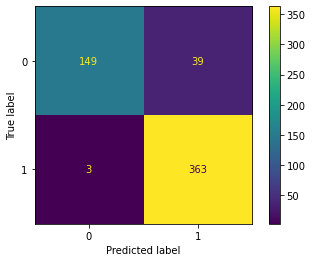

In [66]:
plot_confusion_matrix(lr, X_test, y_test);

### NMF (unsupervised)

In [1]:
nmf = NMF(n_components=4, max_iter=400)
nmf.fit(X)

NameError: name 'NMF' is not defined

In [ ]:
H = nmf.components_
H.shape

In [ ]:
for i, row in enumerate(H):
    top = np.argsort(row)[::-1][:15]
    print(i, ', '.join(vocabulary[top]))

### Stop the presses, random forest 90 percent accurate

In [70]:
rf = RandomForestClassifier(n_estimators=500, max_depth=15)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=500)

In [71]:
rf.score(X_test, y_test)

0.8772563176895307

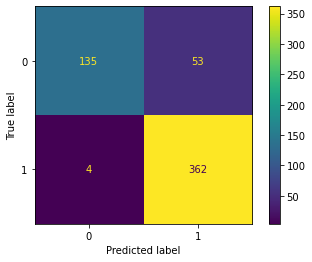

In [64]:
plot_confusion_matrix(rf, X_test, y_test);

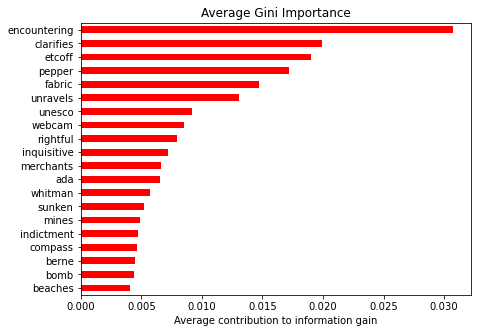

In [65]:
feat_scores = pd.Series(rf.feature_importances_,
                           index=vocabulary)
feat_scores = feat_scores.sort_values()
ax = feat_scores[-20:].plot(kind='barh', 
                      figsize=(7,5),
                      color='r')
ax.set_title('Average Gini Importance')
ax.set_xlabel('Average contribution to information gain');

In [73]:
clf = GradientBoostingClassifier(n_estimators=500,
                                 learning_rate=0.05,
                                 max_depth=20, random_state=36).fit(X_train, y_train)
clf.score(X_test, y_test)

0.8664259927797834